In [1]:
# Import the python library that connects to CoppeliaSim, the file is sim.py.
try:
    import sim

except:
    print('--------------------------------------------------------------')
    print('"sim.py" could not be imported. This means very probably that')
    print('either "sim.py" or the remoteApi library could not be found.')
    print('Make sure both are in the same folder as this file,')
    print('or appropriately adjust the file "sim.py"')
    print('--------------------------------------------------------------')
    print('')

import time
import time
import cv2
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


In [3]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    def get_orientation(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(euler)

# Question 1

In [4]:
#Question 1
import sim as vrep
vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)
images = []
orientation = []
orientation1 = []
if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    
    #Set the robot 
    r = robot(frame_name='Pioneer_p3dx')
    #r = robot(frame_name='Vision_sensor')
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 50
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            
            #Get the orientation of the robot 
            orien = r.get_orientation()
            #orien1 = r1.get_orientation()
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            images.append(img)
            orientation.append(orien)
            #orientation1.append(orien1)
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Robot connected
Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!
image 12 OK!!!
image 13 OK!!!
image 14 OK!!!
image 15 OK!!!
image 16 OK!!!
image 17 OK!!!
image 18 OK!!!
image 19 OK!!!
image 20 OK!!!
image 21 OK!!!
image 22 OK!!!
image 23 OK!!!
image 24 OK!!!
image 25 OK!!!
image 26 OK!!!
image 27 OK!!!
image 28 OK!!!
image 29 OK!!!
image 30 OK!!!
image 31 OK!!!
image 32 OK!!!
image 33 OK!!!
image 34 OK!!!
image 35 OK!!!
image 36 OK!!!
image 37 OK!!!
image 38 OK!!!
image 39 OK!!!
image 40 OK!!!
image 41 OK!!!
image 42 OK!!!
image 43 OK!!!
image 44 OK!!!
image 45 OK!!!
image 46 OK!!!
image 47 OK!!!
image 48 OK!!!
image 49 OK!!!


In [5]:
#Make the image looks same as the sensor 
for i in range(len(images)):
    images[i] = np.flipud(images[i])
    

# Show serveral image to say we have saved images into array 

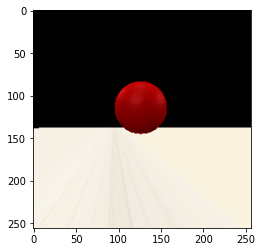

In [6]:
#Second image
imshow(images[0])

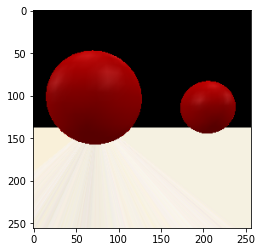

In [7]:
#First image
imshow(images[30])

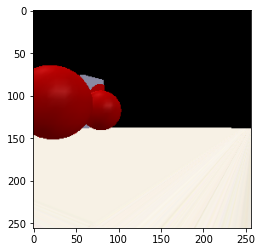

In [8]:
#Last image
imshow(images[49])

In [9]:
orientation= np.array(orientation)
print(orientation)
#print(orientation)

[[ 7.43900542e-04  4.23829071e-03  2.98192477e+00]
 [ 9.63072991e-04  3.83635587e-03  2.91403913e+00]
 [ 1.06064638e-03  3.28377727e-03  2.84606266e+00]
 [ 1.12920138e-03  2.74455850e-03  2.77450871e+00]
 [ 1.10837480e-03  2.20223051e-03  2.70651960e+00]
 [ 1.07789633e-03  1.94835826e-03  2.66820121e+00]
 [ 1.05683820e-03  1.57214503e-03  2.58816648e+00]
 [ 1.12065650e-03  1.43649371e-03  2.52012014e+00]
 [ 1.36549282e-03  1.51715556e-03  2.44601178e+00]
 [ 1.74333819e-03  1.66735251e-03  2.36292338e+00]
 [ 2.36639660e-03  1.83491933e-03  2.25382137e+00]
 [ 2.68917833e-03  1.68636523e-03  2.14986038e+00]
 [ 3.48074036e-03  1.75025361e-03  2.05492067e+00]
 [ 3.38979764e-03  1.18862570e-03  1.92768693e+00]
 [ 2.79310835e-03  5.79123094e-04  1.80291688e+00]
 [ 2.07370659e-03  1.60020543e-04  1.68499565e+00]
 [ 1.73925527e-03 -1.10239023e-04  1.55712211e+00]
 [ 1.88394298e-03 -2.99598672e-04  1.45448267e+00]
 [ 2.54804757e-03 -7.10555410e-04  1.32982624e+00]
 [ 3.19554098e-03 -1.34818919e-

# Question 2

In [10]:
gray_img = []
for im in images:
    # Convert to gray scale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray_img.append(gray)

In [11]:
circle_list = []

for gray_i in gray_img:
    gray = cv2.medianBlur(gray_i,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    print(circles)
    
    #imshow(gray, cmap='gray')
    if circles is not None:
        circle_list.append(np.array(circles))
    else:
        circle_list.append([])

[[[126.5 114.5  30.3]]]
[[[110.5 114.5  30.5]]]
[[[ 95.5 113.5  31.1]]]
[[[ 79.5 113.5  31.2]
  [254.5 112.5  28.8]]]
[[[ 61.5 115.5  34.1]
  [241.5 108.5  36.6]]]
[[[ 53.5 113.5  32.1]
  [227.5 113.5  30.3]]]
[[[212.5 115.5  32.3]
  [ 32.5 115.5  36.5]]]
[[[195.5 116.5  32.1]
  [ 18.5 111.5  34.2]]]
[[[176.5 115.5  30.2]]]
[[[157.5 115.5  28.8]]]
[[[133.5 114.5  28.3]]]
[[[111.5 115.5  28.3]]]
[[[ 88.5 115.5  28.8]
  [239.5 103.5  44.9]]]
[[[ 57.5 114.5  29.9]
  [214.5 105.5  49. ]]]
[[[184.5 105.5  48.1]
  [ 32.5 115.5  27.9]]]
[[[157.5 107.5  46.5]]]
[[[128.5 106.5  46.9]]]
[[[105.5 107.5  46. ]]]
[[[ 73.5 106.5  47.2]]]
[[[ 42.5 107.5  51.5]
  [244.5 107.5  21.3]]]
[[[208.5 115.5  27.3]
  [ 11.5 101.5  54.5]]]
[[[176.5 116.5  25.7]]]
[[[147.5 118.5  27.5]]]
[[[119.5 116.5  26. ]]]
[[[ 92.5 115.5  26. ]]]
[[[ 61.5 115.5  27.4]
  [221.5 107.5  47.9]]]
[[[203.5 102.5  56.4]
  [ 31.5 117.5  30.2]]]
[[[175.5 104.5  56.2]
  [  6.5 115.5  25.8]]]
[[[135.5 102.5  52.2]
  [106.5  86.5  21. 

In [12]:
#A function to draw the circles on the image 
def draw_circle(cir):
    if cir is not None:
        for circle in cir:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels

            # plot circle
            s = linspace(0,2*pi,100)
            cx = cos(s)*radius + center [0]
            cy = sin(s)*radius + center [1]
            # Plot center
            plot(center[0], center[1], '*')

            plot(cx,cy)

# Show random several images's circle without the for loop, because the Jupyter could not print all of images at once 

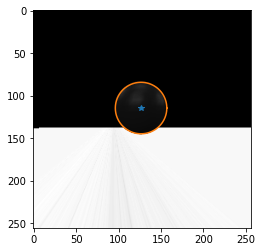

In [13]:
 # 1
imshow(gray_img[0], cmap='gray')
draw_circle(circle_list[0][0])

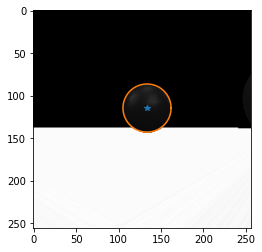

In [14]:
#10
imshow(gray_img[10], cmap='gray')
draw_circle(circle_list[10][0])

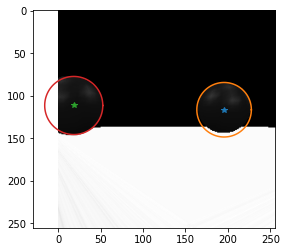

In [15]:
#8
imshow(gray_img[7], cmap='gray')
draw_circle(circle_list[7][0])

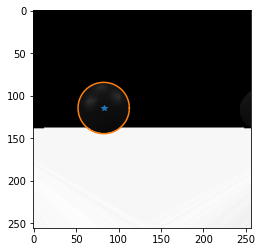

In [16]:
#36
imshow(gray_img[35], cmap='gray')
draw_circle(circle_list[35][0])

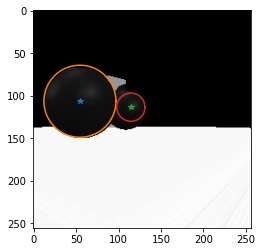

In [17]:
#49
imshow(gray_img[48], cmap='gray')
draw_circle(circle_list[48][0])

# Question 3

In [18]:
#A function to calculate the distance between the robot and sphere
def cal_distance(radius,center):
    u0, v0 = 132, 132
    dist = []
    k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
    fov = 60  # degrees

    # number of pixels in x-axis
    npx = 264

    # maximum value in the x-axis (in meters)
    xmax = npx / (2.* k)

    # Distance to the center of the sphere (z-axis coordinate)
    zc = xmax / tan(pi/6)
    

    # Location of the sphere in the x-axis coordinate
    xc = (center[0] - u0) / k
    dist.append(xc)
    dist.append(zc)
    dist = np.array(dist)
    return dist

In [19]:
import math
def RotZ(angle):
    rot= np.array([[math.cos(angle), -(math.sin(angle))], [math.sin(angle), math.cos(angle)]])
    return rot

In [20]:
import numpy as np
#Find all of distance between the robotics and spheres and saved into one array in world frame
distance_list = []
radius_list =[]
orien_list = []
for i in range(len(circle_list)):
    cir = circle_list[i][0]
    if cir is not None:
        for circle in cir:
            #Center
            cen = (circle[0], circle[1])  # In pixels
            #print("Center,", cen )
            #Radius
            rad = circle[2]  # In pixels
            radius_list.append(rad)
            #First, getting the distance in the camera frame 
            distance = cal_distance(rad,cen)
            #print("distance b:", distance)
            
            #Second, Calculating the Z axis rotation matrix 
            #rotZ1 = RotZ(orientation1[i][2])
            rotZ = RotZ(orientation[i][2])
            orien_list.append(orientation[i])
            #Make the dot product to find the world frame matrix
            p1 = np.dot(rotZ,distance)
            #p1 = np.dot(rotZ,p1)
            distance_list.append(p1)
            
distance_list

[array([-0.76534726, -5.60883685]),
 array([-0.75324933, -5.59640593]),
 array([-0.76375411, -5.53093888]),
 array([-0.79452207, -5.58271235]),
 array([-5.11440761, -4.41234865]),
 array([-0.71327722, -5.21360881]),
 array([-4.00945513, -3.30286094]),
 array([-0.80297409, -5.59056762]),
 array([-4.68396117, -3.95911887]),
 array([-4.38049041, -3.53385838]),
 array([-0.72990307, -5.07124125]),
 array([-4.31643088, -3.47920576]),
 array([-0.89557761, -5.52555329]),
 array([-4.48697629, -3.65062699]),
 array([-4.65434856, -3.77190127]),
 array([-4.72494755, -3.79333096]),
 array([-4.77402298, -3.77051368]),
 array([-4.74246781, -3.77378907]),
 array([-4.21588882, -0.18818463]),
 array([-4.72065174, -3.75452931]),
 array([-3.72010031, -0.03939037]),
 array([-3.65763312, -0.0234295 ]),
 array([-5.36585638, -4.01683039]),
 array([-3.71043938, -0.01159446]),
 array([-3.65656475, -0.00597161]),
 array([-3.75262922e+00,  3.45662938e-03]),
 array([-3.74977086, -0.03572392]),
 array([-3.57559316,

In [21]:
orien_list = np.array(orien_list)


# Question 4

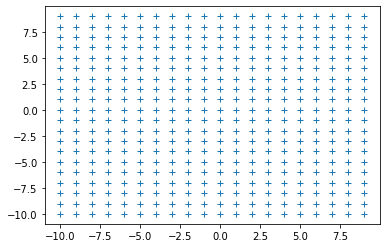

In [22]:
# Grid Representation

# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

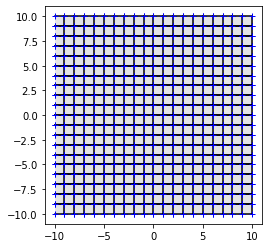

In [23]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

In [24]:
def make_measurement(n,grid_x,gird_y,cell_w,xc,zc,radius,k,orien):
    l0 = (0.3/(1-0.3))  # Initial belief
    gmap = l0 * ones(n*n) # Initial belief

    # For each cell, check if the circle is in it.
    for i in range(n*n):
        x, y = grid_x[i], grid_y[i]
        #TODO Run this for each sphere (center and radius)
        # Corners of the cell
        X, Y = points_cell(x, y, cell_w)
        # check based on the ecuclidean distance
        dist = sqrt((xc - X)**2 + (zc - Y)**2)

        # Check if At least one of the borders is within the sphere
        if((dist < radius/k).any()):
            #print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            #print(li)
        else:
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            #Using real orientation of the robot
            thetas = np.arctan2(orien[1],orien[0]) - pi/2
            #thetas = np.arctan2(Y,X) - pi/2
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li
            pass

    return gmap

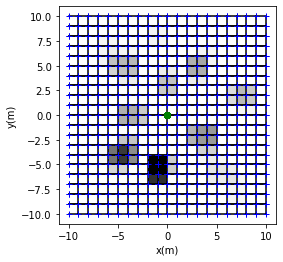

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# gmap_list = []
#Adding all of gmap together
gmap = make_measurement(n,grid_x,grid_y,cell_w,distance_list[1][0],distance_list[1][1],radius_list[1],(radius_list[1] / (1.5 / 2)),orien_list[1])
for i in range(len(distance_list)-1):
    gmap1 = make_measurement(n,grid_x,grid_y,cell_w,distance_list[i+1][0],distance_list[i+1][1],radius_list[i+1],(radius_list[i+1] / (1.5 / 2)),orien_list[i+1])
    #print(gmap1)
    gmap += gmap1

 # normalize gmap   
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)    

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))

    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
xlabel('x(m)')
ylabel('y(m)')
fig.canvas.draw()
#fig.show()